In [39]:
import os
from PIL import Image
from torchvision import transforms, datasets
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt

import torch.optim as optim

import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from dataset import ImageDataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

root_dir = "../MLChallenge_Dataset/Data"
dataset = ImageDataset(root_dir,transform=transforms.ToTensor())

In [44]:
#load the dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#carrega o dataset de treino e teste

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

#verifica o tamanho do dataset de treino e teste
print("Train dataset size: ", len(train_dataset))
print("Test dataset size: ", len(test_dataset))

Train dataset size:  23268
Test dataset size:  5817


torch.Size([3, 480, 640])


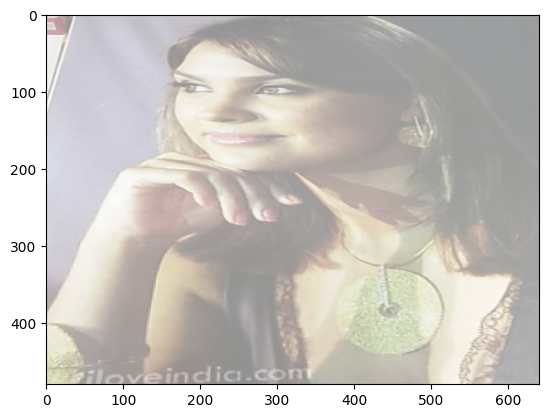

Label: 0


In [66]:
#Testando se o dataset está carregando corretamente

images, labels = train_loader.dataset[0]
print(images.shape)

def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#show images
imshow(torchvision.utils.make_grid(images))

#show labels
print(f"Label: {labels}")


class_ratios: [0.67 0.33]


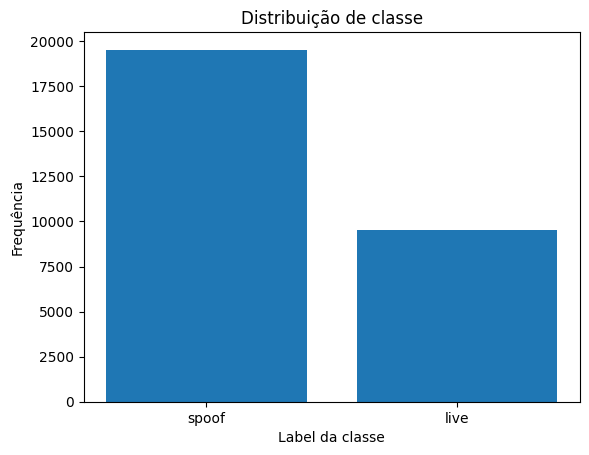

In [63]:
#Verificando se há class imbalance no dataset
#Label 0: spoof, Label 1: live

class_counts = np.bincount(dataset.labels)
num_classes = len(class_counts)
class_indices = np.arange(num_classes)

class_ratios = np.round(class_counts / len(dataset.labels),2)
print(f"class_ratios: {class_ratios}")

plt.bar(class_indices, class_counts)
plt.xticks(class_indices, ['spoof', 'live'])
plt.xlabel('Label da classe')
plt.ylabel('Frequência')
plt.xticks(class_indices)
plt.title('Distribuição de classe')
plt.show()



In [67]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5) #3 canais de entrada, 6 canais de saída, kernel 5x5
        self.pool = nn.MaxPool2d(2, 2) #kernel 2x2, stride 2
        self.conv2 = nn.Conv2d(6, 16, 5) #6 canais de entrada, 16 canais de saída, kernel 5x5

        self.fc1 = nn.Linear(16 * 53 * 53, 120) #16 canais de entrada, 120 canais de saída
        self.fc2 = nn.Linear(120, 84) #120 canais de entrada, 84 canais de saída
        self.fc3 = nn.Linear(84, 2) #84 canais de entrada, 2 canais de saída

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #primeira camada de convolução
        x = self.pool(F.relu(self.conv2(x))) #segunda camada de convolução
        x = x.view(-1, 16 * 53 * 53) #transforma o tensor em um vetor
        x = F.relu(self.fc1(x)) #primeira camada linear
        x = F.relu(self.fc2(x)) #segunda camada linear
        x = self.fc3(x) #terceira camada linear
        return x


In [68]:
net = Net()

#definindo a função de perda e o otimizador

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #lr = learning rate

#treinando a rede

for epoch in range(10): #loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        #get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

RuntimeError: stack expects each tensor to be equal size, but got [3, 600, 450] at entry 0 and [3, 600, 449] at entry 1

In [ ]:
#testando a rede

images, labels = dataiter.dataset[0:4]

#print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j].item() for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j].item() for j in range(4)))

#calculando a acurácia da rede

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total))

#calculando a acurácia por classe

class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)

        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(32):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print("Accuracy of %5s : %2d %%" % (i, 100 * class_correct[i] / class_total[i]))

#salvando o modelo

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)